In [125]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import TensorBoard
from time import time
import itertools

In [126]:
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [127]:
def generateData(data, perm):
    n = data.shape[0]
    blockSize = n // len(perm)
    dataSet = np.zeros(data[0].shape)
    for i in perm:
        block = data[i*blockSize:(i+1)*blockSize]
        print(block, end='\n\n')
        dataSet = np.vstack((dataSet, block))
    dataSet = dataSet[1:]
    return dataSet

In [128]:
# dataframe = read_csv('sp500.csv')
fields = ['open', 'close']
dataframe = read_csv('GOOGL_data.csv', skipinitialspace = True, squeeze = True, usecols = fields)

print(dataframe.head())
data = np.array(dataframe)[:20]
print(data.shape)

       open     close
0  390.4551  393.0777
1  389.5892  391.6012
2  391.2659  390.7403
3  390.4551  391.8214
4  390.2549  394.3039
(20, 2)


In [129]:
# dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data[:5])

[[0.02762588 0.08065284]
 [0.         0.02970567]
 [0.05349383 0.        ]
 [0.02762588 0.03730375]
 [0.02123865 0.12296332]]


In [130]:
split = 0.60
trainSize = int(len(data)*split)
testSize = len(data)-trainSize
print(trainSize)
print(testSize)

12
8


In [131]:
numInterval = 2
blockSize = trainSize//numInterval
print(blockSize)


6


In [132]:
    train = data[0:trainSize,:]
    test = data[trainSize:len(data),:]
    print(train[:5])

[[0.02762588 0.08065284]
 [0.         0.02970567]
 [0.05349383 0.        ]
 [0.02762588 0.03730375]
 [0.02123865 0.12296332]]


[[0.02762588 0.08065284]
 [0.         0.02970567]
 [0.05349383 0.        ]
 [0.02762588 0.03730375]
 [0.02123865 0.12296332]
 [0.14371263 0.21052069]
 [0.28087852 0.45160968]
 [0.42954268 0.20309513]
 [0.31297418 0.25611608]
 [0.33309299 0.32830475]
 [0.38163847 0.17391049]
 [0.26506997 0.16285842]]

(0, 1)
[[0.02762588 0.08065284]
 [0.         0.02970567]
 [0.05349383 0.        ]
 [0.02762588 0.03730375]
 [0.02123865 0.12296332]
 [0.14371263 0.21052069]]

[[0.28087852 0.45160968]
 [0.42954268 0.20309513]
 [0.31297418 0.25611608]
 [0.33309299 0.32830475]
 [0.38163847 0.17391049]
 [0.26506997 0.16285842]]

[[0.02762588 0.08065284]
 [0.         0.02970567]
 [0.05349383 0.        ]
 [0.02762588 0.03730375]
 [0.02123865 0.12296332]
 [0.14371263 0.21052069]
 [0.28087852 0.45160968]
 [0.42954268 0.20309513]
 [0.31297418 0.25611608]
 [0.33309299 0.32830475]
 [0.38163847 0.17391049]
 [0.26506997 0.16285842]]
_________________________________________________________________
Layer (type)        

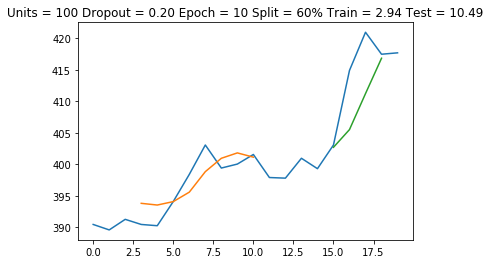

(1, 0)
[[0.28087852 0.45160968]
 [0.42954268 0.20309513]
 [0.31297418 0.25611608]
 [0.33309299 0.32830475]
 [0.38163847 0.17391049]
 [0.26506997 0.16285842]]

[[0.02762588 0.08065284]
 [0.         0.02970567]
 [0.05349383 0.        ]
 [0.02762588 0.03730375]
 [0.02123865 0.12296332]
 [0.14371263 0.21052069]]

[[0.28087852 0.45160968]
 [0.42954268 0.20309513]
 [0.31297418 0.25611608]
 [0.33309299 0.32830475]
 [0.38163847 0.17391049]
 [0.26506997 0.16285842]
 [0.02762588 0.08065284]
 [0.         0.02970567]
 [0.05349383 0.        ]
 [0.02762588 0.03730375]
 [0.02123865 0.12296332]
 [0.14371263 0.21052069]]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 41,402
Trainable params: 41,402
Non-trainabl

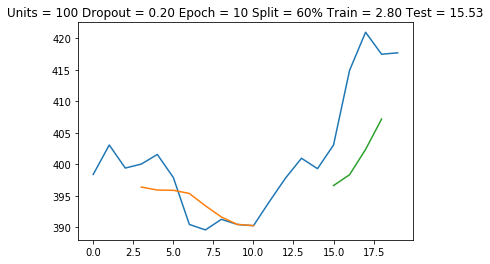

In [133]:
print(train, end="\n\n")
permutations = itertools.permutations(range(numInterval))
for perm in permutations:
    print(perm)
    trainSet = generateData(train, perm)
    trainSet = np.reshape(trainSet, train.shape)
    print(trainSet)
    shuffleData = np.vstack((trainSet, test))

    lookBack = 3
    trainX, trainY = create_dataset(trainSet, lookBack)
    testX, testY = create_dataset(test, lookBack)
#     print(trainX.shape)
    # print(trainY[:5])

    # trainX = np.reshape(trainX, (trainX.shape[0], 2, trainX.shape[1]))
    # testX = np.reshape(testX, (testX.shape[0], 2, testX.shape[1]))

    units = 100
    drop = 0.2
    epoch = 10

    model = Sequential()
    model.add(LSTM(units, input_shape=(lookBack, 2)))
    # model.add(Dropout(drop))
    model.add(Dense(2))
    # model.compile(loss='mean_squared_error', optimizer='adam')
    model.compile(loss='mean_squared_error', optimizer='nadam')
    model.summary()
    tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
    model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1, callbacks=[tensorboard])

    # print(trainX.shape)
    trainPredict = model.predict(trainX)
    # print(trainPredict.shape)
    # print(testX.shape)
    testPredict = model.predict(testX)
    # print(testPredict.shape)

    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)

    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))

    trainPredictPlot = np.empty_like(shuffleData)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    testPredictPlot = np.empty_like(shuffleData)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict

    # print(data.shape)
    # print(train.shape)
    # print(test.shape)
    # print(trainPredict.shape)
    # print(testPredict.shape)

    col = 0
    plt.plot(scaler.inverse_transform(shuffleData)[:,col])
    plt.plot(trainPredictPlot[:,col])
    plt.plot(testPredictPlot[:,col])
    plt.title('Units = %d Dropout = %.2f Epoch = %d Split = %d%% Train = %.2f Test = %.2f' % 
            (units, drop, epoch, split*100, trainScore, testScore))
    plt.show()